# Parallelization
In LangGraph, nodes typically execute in a sequence defined by edges, but when tasks don't depend on each other's outputs, you can run them in parallel. This is achieved by:

- Defining multiple nodes that can operate independently.
- Connecting them to a common starting point (e.g., START or another node).
- Merging their outputs into a downstream node if needed.

In [46]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict
from langchain_groq import ChatGroq

In [47]:
class state(TypedDict):
    topic:str
    characters:str
    settings:str
    premises:str
    story_intro:str

In [48]:
llm=ChatGroq(model='llama-3.1-8b-instant')

In [49]:
def gen_characters(state):
    res=llm.invoke(f"Create two character names and brief traits for a story about {state['topic']}")
    return {'characters':res.content}

In [50]:
def gen_settings(state):
    res=llm.invoke(f"Describe a vivid setting for a story aboud : {state['topic']}")
    return {'settings':res.content}

In [51]:
def gen_premise(state):
    res=llm.invoke(f"write a 1 sentence premise about a story {state['topic']}")
    return{
        'premises':res.content
    }


In [52]:
def combine_element(state):
    res=llm.invoke(
            f"write a short story introduction using these elements \n characters: {state['characters']} \n Settings : {state['settings']} \n premises: {state['premises']}")
    return {
        'story_intro':res.content
    }


In [53]:
graph=StateGraph(state)

graph.add_node('gen_character',gen_characters)
graph.add_node('gen_settings',gen_settings)
graph.add_node('gen_premise',gen_premise)
graph.add_node('combine_element',combine_element)

graph.add_edge(START,'gen_character')
graph.add_edge(START,'gen_settings')
graph.add_edge(START,'gen_premise')
graph.add_edge('gen_character','combine_element')
graph.add_edge('gen_settings','combine_element')
graph.add_edge('gen_premise','combine_element')
graph.add_edge('combine_element',END)

In [54]:
workflow=graph.compile()

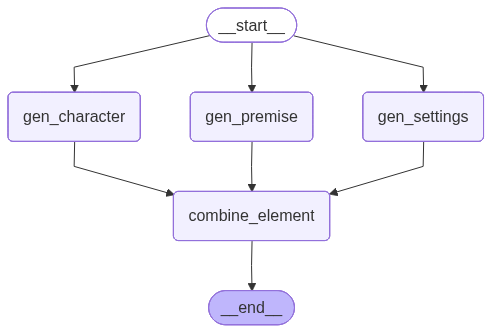

In [55]:
workflow

In [56]:
workflow.invoke({'topic':'time travel'})

{'topic': 'time travel',
 'characters': 'Here are two potential character names and brief traits for a story about time travel:\n\n1. **Name:** Emilia "Mia" Thompson\n**Age:** 25\n**Occupation:** Historian and Temporal Physicist\n**Personality:** Mia is a brilliant and resourceful individual with a passion for history. She\'s fiercely independent and has a strong sense of curiosity. Her analytical mind often gets her into trouble, but she\'s always willing to take calculated risks to uncover the truth.\n**Physical Description:** Mia has short, curly brown hair and bright green eyes. She\'s petite, but has a wiry physique that belies her intelligence and determination.\n\n2. **Name:** Julian "Jules" Blackwood\n**Age:** 30\n**Occupation:** Temporal Agent (Time Traveler)\n**Personality:** Jules is a charming and resourceful individual with a talent for getting out of tight spots. He\'s been trained as a Temporal Agent, and has a wealth of experience navigating the complexities of time tra